### Predicting with Logistic regression, Random forest classifier and Gradient boosting classifier

In [ ]:
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, "..")
from eis_toolkit.prediction.logistic_regression import logistic_regression_train
from eis_toolkit.prediction.random_forests import random_forest_classifier_train
from eis_toolkit.prediction.gradient_boosting import gradient_boosting_classifier_train
from eis_toolkit.prediction.machine_learning_general import prepare_data_for_ml, reshape_predictions
from eis_toolkit.prediction.machine_learning_predict import predict_classifier

In [2]:
# Training filepaths
AEM_inphase_fp = "../tests/data/local/workflow_demo/clipped/AEM_inph_clipped.tif"
AEM_quad_fp = "../tests/data/local/workflow_demo/clipped/AEM_quad_clipped.tif"
EM_ratio_fp = "../tests/data/local/workflow_demo/clipped/EM_ratio_clipped.tif"
magnetic_fp = "../tests/data/local/workflow_demo/clipped/magnetic_clipped.tif"
distances_fp = "../tests/data/local/workflow_demo/clipped/distances_clipped.tif"

training_data_filepaths = [AEM_inphase_fp, AEM_quad_fp, EM_ratio_fp, magnetic_fp, distances_fp]

input_rasters = {
    "AEM_inphase": AEM_inphase_fp,
    "AEM_quad": AEM_quad_fp,
    "EM_ratio": EM_ratio_fp,
    "magnetic": magnetic_fp,
    "distances_to_structures": distances_fp,
}

deposits_fp = "../tests/data/local/workflow_demo/clipped/deposits_clipped.gpkg"
deposits_rasterized_fp = "../tests/data/local/workflow_demo/clipped/deposits_rasterized.tif"

In [3]:
# Test filepaths
test_data_filepaths = [
    "../tests/data/local/workflow_demo/unified/AEM_Inph.tif",
    "../tests/data/local/workflow_demo/unified/AEM_Quad.tif",
    "../tests/data/local/workflow_demo/unified/EM_ratio.tif",
    "../tests/data/local/workflow_demo/unified/IOCG_Magnetic.tif",
    "../tests/data/local/workflow_demo/distances_raster.tif"
]

deposits_fp_test = "../tests/data/local/workflow_demo/Deposits_Occurrences/IOCG_Deps_Prosp_Occs_2.shp"

In [4]:
# Parameters for the notebook
colormap_name = "jet"
save = True
random_state = 42

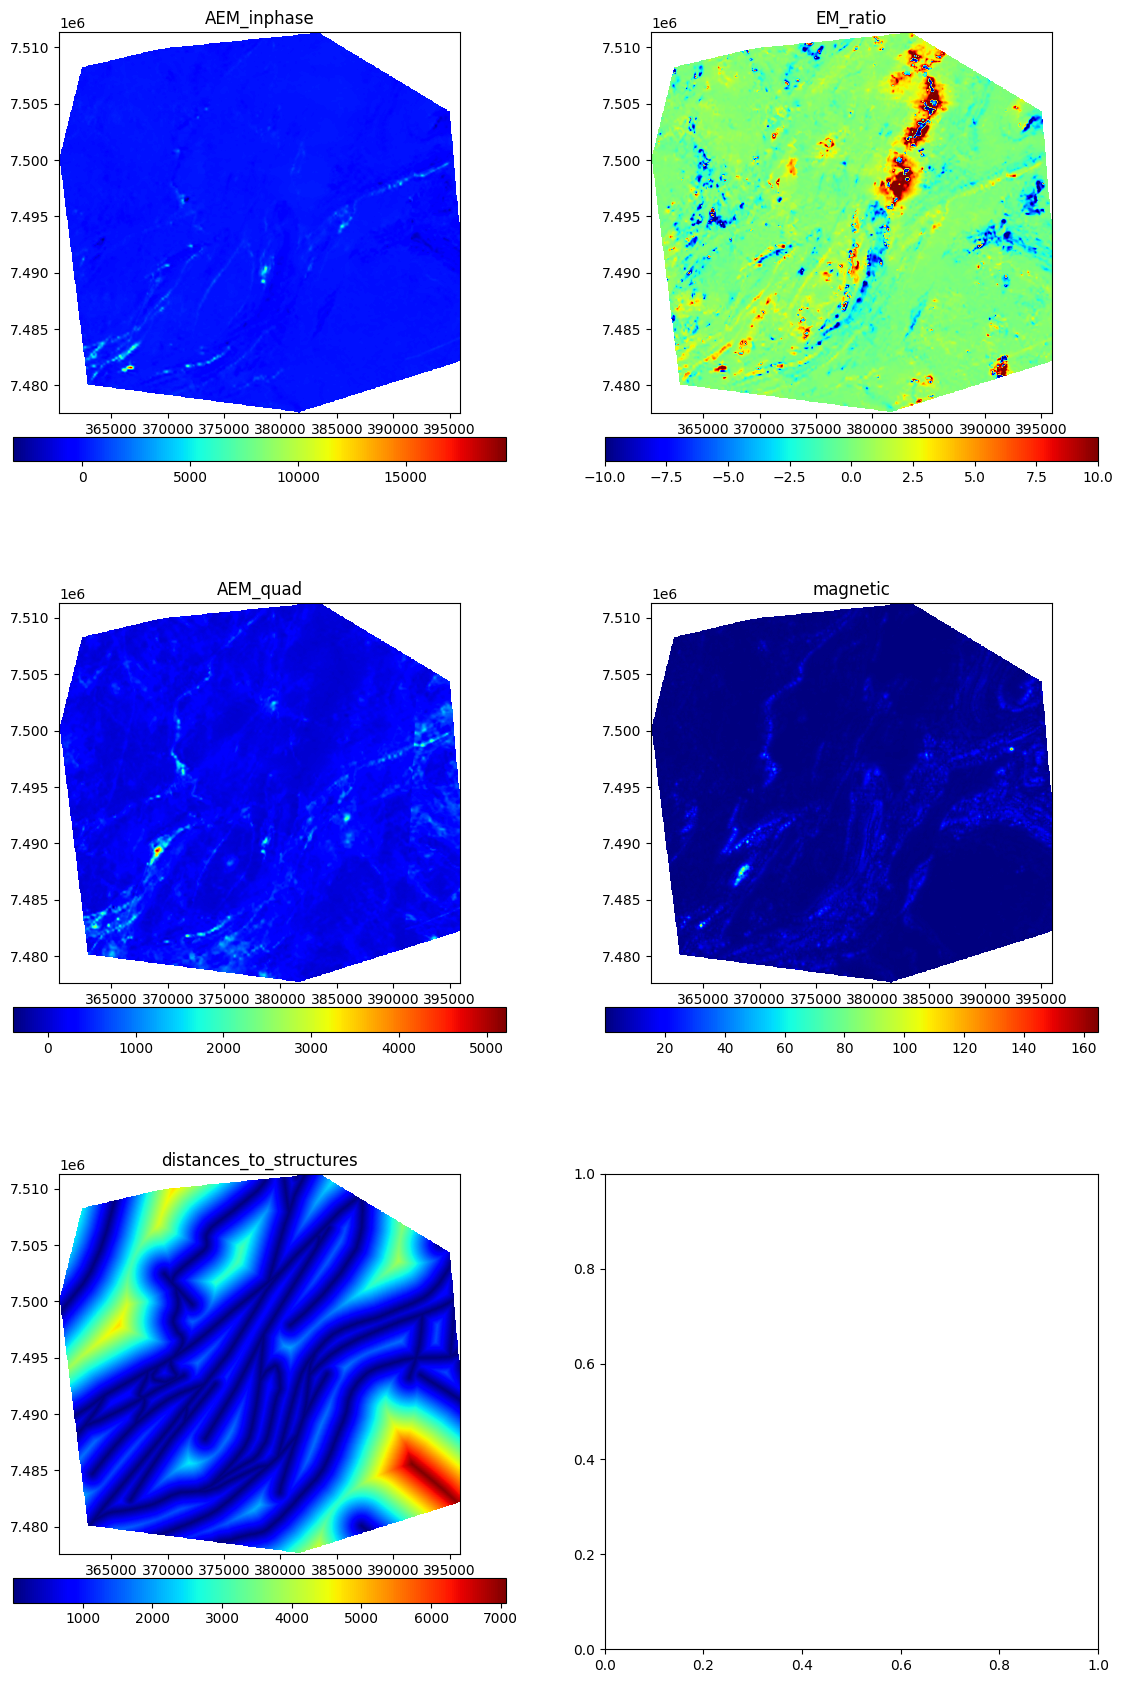

In [5]:
# Plot input rasters
plot_idx = [(0, 0), (1, 0), (0, 1), (1, 1), (2, 0)]

fig, axs = plt.subplots(3, 2, figsize = (14, 21))

for idx, raster_name in zip(plot_idx, input_rasters.keys()):
    fp = input_rasters[raster_name]
    with rasterio.open(fp) as raster:
        data = raster.read()
        meta = raster.meta.copy()
        data[data == meta["nodata"]] = np.nan  # To plot correctly
        axs[idx[0], idx[1]].set_title(raster_name)
        clrbar = axs[idx[0], idx[1]].imshow(data[0], cmap=colormap_name)
        plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
        show(data[0], ax = axs[idx[0], idx[1]], transform = meta["transform"], cmap=colormap_name)

In [6]:
# Prepare data for modeling
X_train, y_train, _, _ = prepare_data_for_ml(training_data_filepaths, deposits_rasterized_fp)

X_test, y_test, reference_meta, nodata_mask = prepare_data_for_ml(test_data_filepaths, deposits_fp_test)

### Logistic regression

In [7]:
# Train logistic regression model, print validation score
lr_model, lr_metrics = logistic_regression_train(
    X=X_train,
    y=y_train,
    validation_method="kfold_cv",
    max_iter=500,
    metrics=['accuracy', 'precision', 'recall', 'f1'],
    random_state=random_state
)
lr_metrics

{'accuracy': {'accuracy_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'accuracy_mean': 0.9999657822423798,
  'accuracy_std': 4.8881230785724485e-06},
 'precision': {'precision_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'precision_mean': 0.9999657822423798,
  'precision_std': 4.8881230785724485e-06},
 'recall': {'recall_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'recall_mean': 0.9999657822423798,
  'recall_std': 4.8881230785724485e-06},
 'f1': {'f1_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'f1_mean': 0.9999657822423798,
  'f1_std': 4.8881230785724485e-06}}

In [8]:
# Predict using the same data as was used for training (for "validation" map)
lr_predictions = predict_classifier(X_test, lr_model, include_probabilities=False)

# Reshape into 2D format and fill with nodata
lr_predictions_reshaped = reshape_predictions(lr_predictions, reference_meta["height"], reference_meta["width"], nodata_mask)

np.nanmax(lr_predictions_reshaped)

0.0

<Axes: title={'center': 'Logistic regression predictons'}>

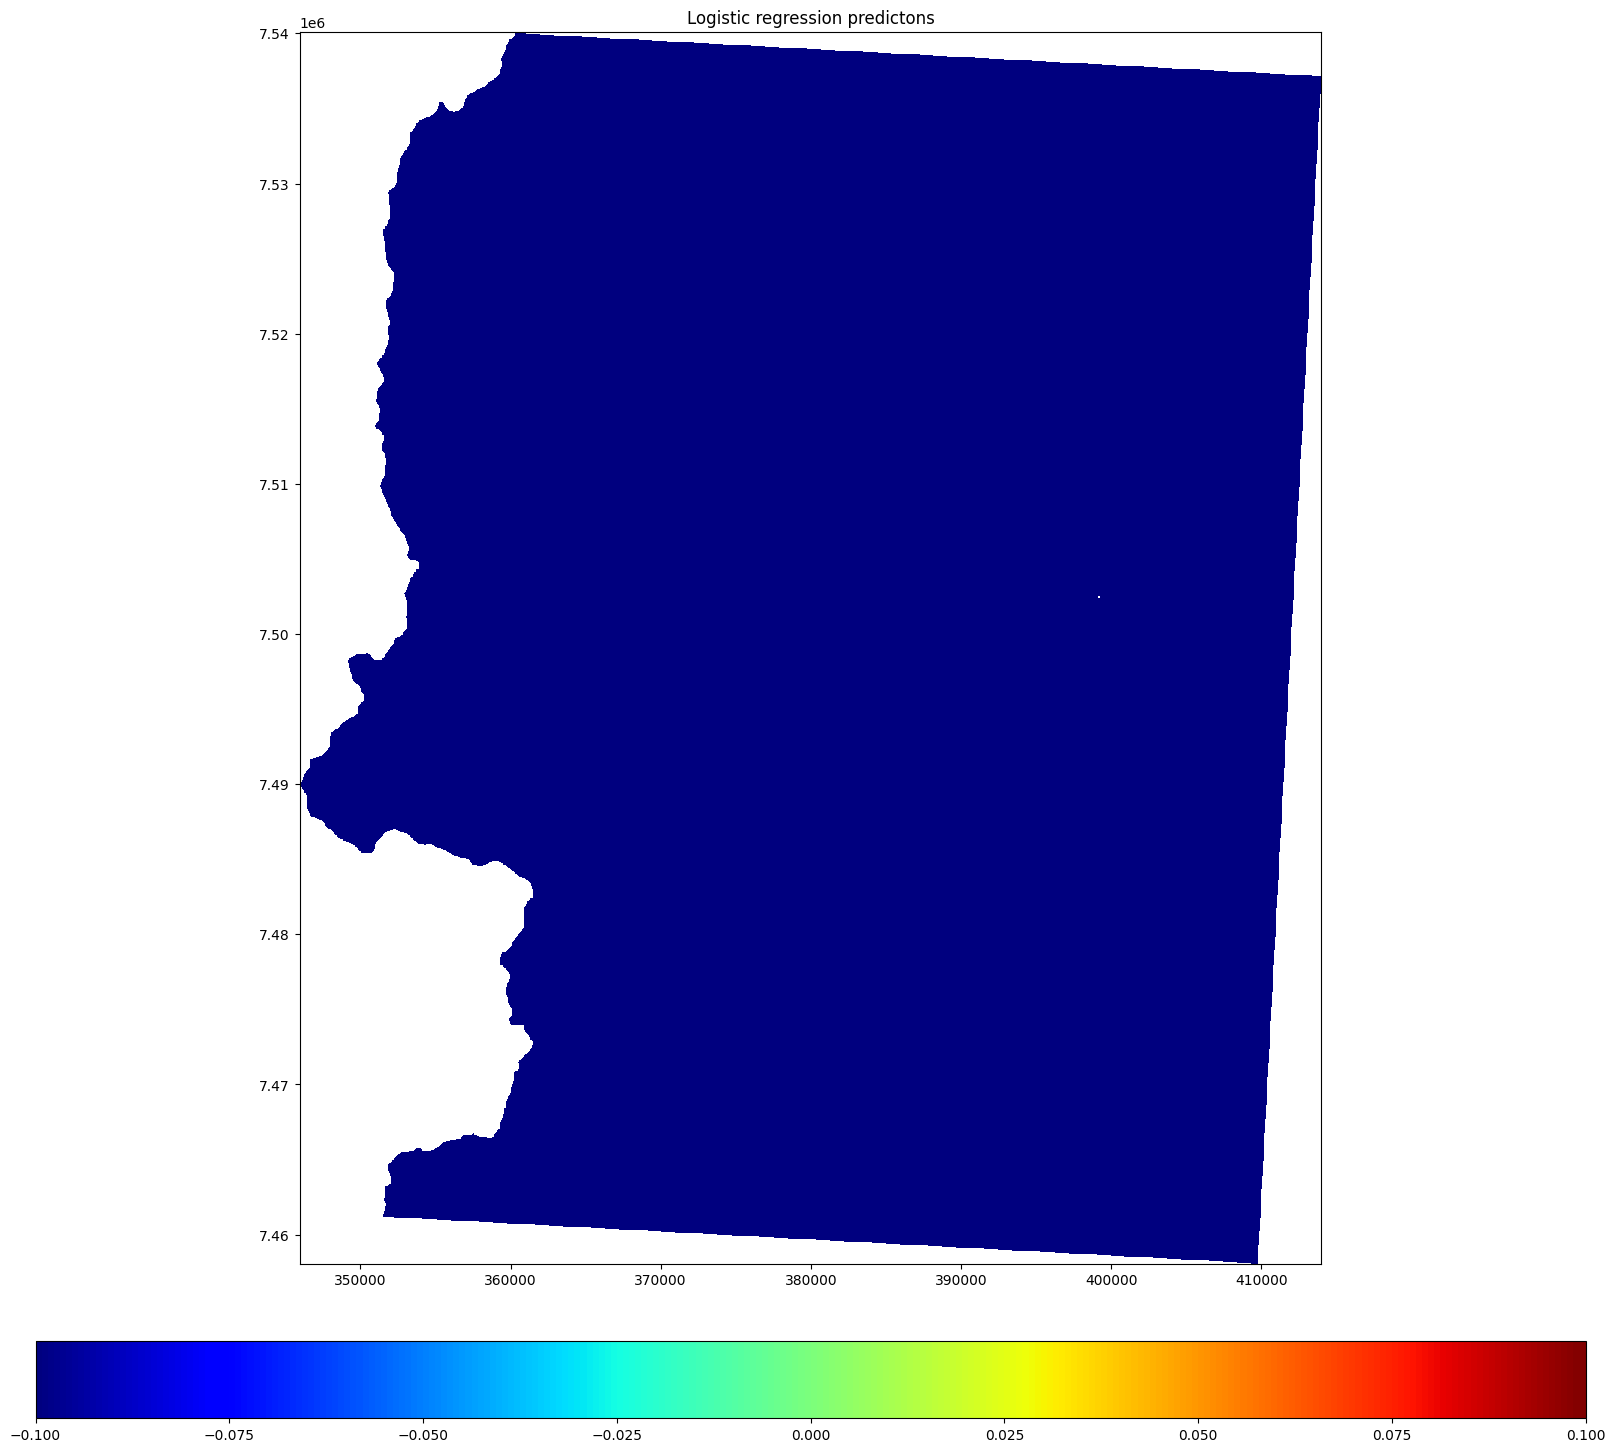

In [9]:
# Visualize output
fig, ax = plt.subplots(figsize = (20, 20))

ax.set_title("Logistic regression predictons")
clrbar = ax.imshow(lr_predictions_reshaped, cmap=colormap_name)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(lr_predictions_reshaped, ax = ax, transform = reference_meta["transform"], cmap=colormap_name)

### Random forest classifier

In [10]:
# Train random forest classifier model, print validation score
rf_model, rf_metrics = random_forest_classifier_train(
    X=X_train,
    y=y_train,
    validation_method="kfold_cv",
    metrics=['accuracy', 'precision', 'recall', 'f1'],
    random_state=random_state
)
rf_metrics

{'accuracy': {'accuracy_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'accuracy_mean': 0.9999657822423798,
  'accuracy_std': 4.8881230785724485e-06},
 'precision': {'precision_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'precision_mean': 0.9999657822423798,
  'precision_std': 4.8881230785724485e-06},
 'recall': {'recall_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'recall_mean': 0.9999657822423798,
  'recall_std': 4.8881230785724485e-06},
 'f1': {'f1_all': [0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999633381808405,
   0.9999755584885369],
  'f1_mean': 0.9999657822423798,
  'f1_std': 4.8881230785724485e-06}}

In [11]:
# Predict using the same data as was used for training (for "validation" map)
rf_predictions = predict_classifier(X_test, rf_model, include_probabilities=False)

# Reshape into 2D format and fill with nodata
rf_predictions_reshaped = reshape_predictions(rf_predictions, reference_meta["height"], reference_meta["width"], nodata_mask)

np.count_nonzero(rf_predictions_reshaped == 1)

14

<Axes: title={'center': 'Random forest classifier predictons'}>

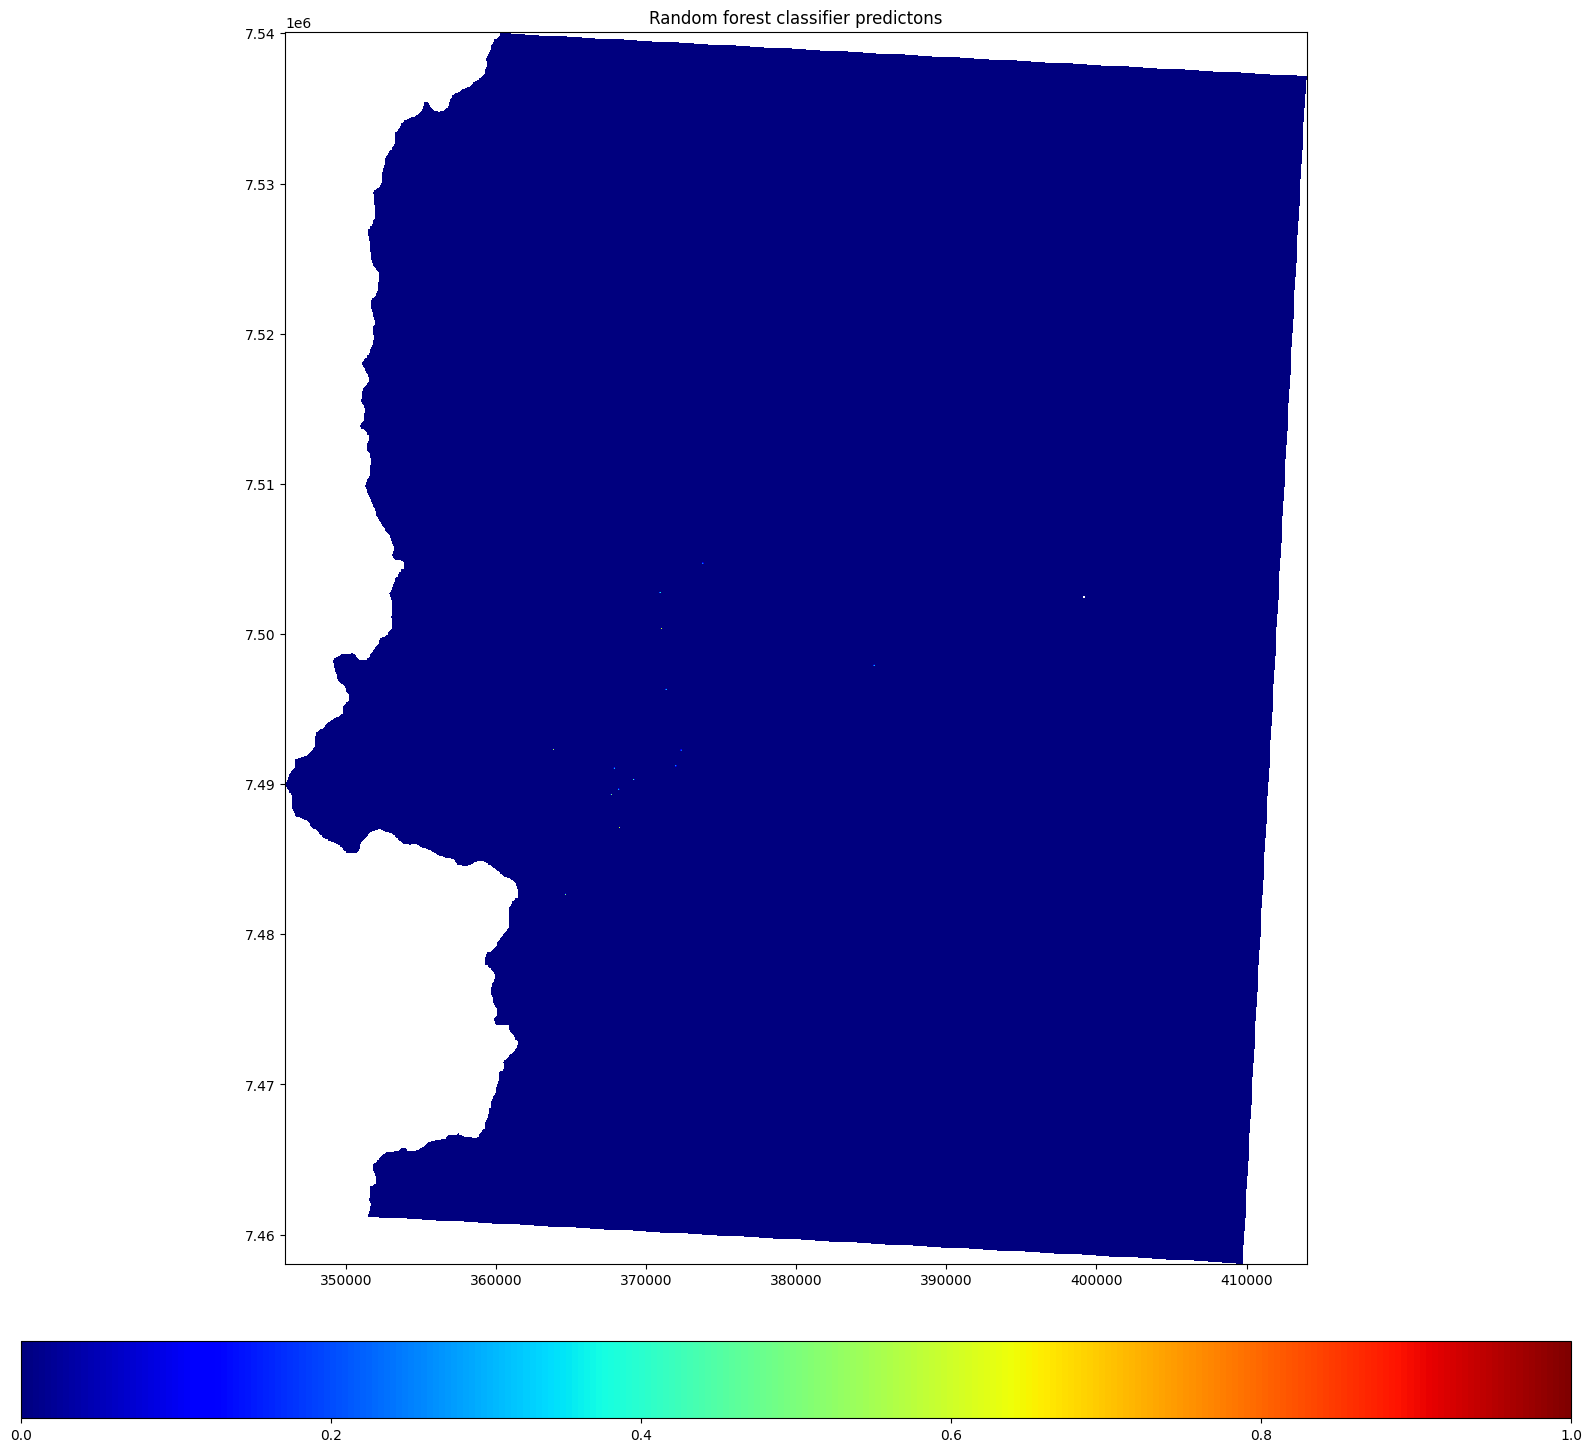

In [12]:
# Visualize output
fig, ax = plt.subplots(figsize = (20, 20))

ax.set_title("Random forest classifier predictons")
clrbar = ax.imshow(rf_predictions_reshaped, cmap=colormap_name)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(rf_predictions_reshaped, ax = ax, transform = reference_meta["transform"], cmap=colormap_name)

In [13]:
rf_classifier_predictions_fp = "../tests/data/local/workflow_demo/clipped/rf_classifier_predictions_output.tif"
if save:
    with rasterio.open(rf_classifier_predictions_fp, "w", **reference_meta) as dest:
        dest.write(rf_predictions_reshaped, 1)

### Gradient boosting classifier

In [14]:
# Train gradient boosting classifier model, print validation score
gb_model, gb_metrics = gradient_boosting_classifier_train(
    X=X_train,
    y=y_train,
    validation_method="kfold_cv",
    metrics=['accuracy', 'precision', 'recall', 'f1'],
    random_state=random_state
)
gb_metrics

{'accuracy': {'accuracy_all': [0.9998655733297486,
   0.9999022351489081,
   0.9999266763616811,
   0.9998655733297486,
   0.9998533509312216],
  'accuracy_mean': 0.9998826818202616,
  'accuracy_std': 2.743557647658361e-05},
 'precision': {'precision_all': [0.9998655733297486,
   0.9999022351489081,
   0.9999266763616811,
   0.9998655733297486,
   0.9998533509312216],
  'precision_mean': 0.9998826818202616,
  'precision_std': 2.743557647658361e-05},
 'recall': {'recall_all': [0.9998655733297486,
   0.9999022351489081,
   0.9999266763616811,
   0.9998655733297486,
   0.9998533509312216],
  'recall_mean': 0.9998826818202616,
  'recall_std': 2.743557647658361e-05},
 'f1': {'f1_all': [0.9998655733297486,
   0.9999022351489081,
   0.9999266763616811,
   0.9998655733297486,
   0.9998533509312216],
  'f1_mean': 0.9998826818202616,
  'f1_std': 2.743557647658361e-05}}

In [15]:
# Predict using the same data as was used for training (for "validation" map)
gb_predictions = predict_classifier(X_test, gb_model, include_probabilities=False)

# Reshape into 2D format and fill with nodata
gb_predictions_reshaped = reshape_predictions(gb_predictions, reference_meta["height"], reference_meta["width"], nodata_mask)

np.count_nonzero(gb_predictions_reshaped == 1)

195

<Axes: title={'center': 'Gradient boosting classifier predictons'}>

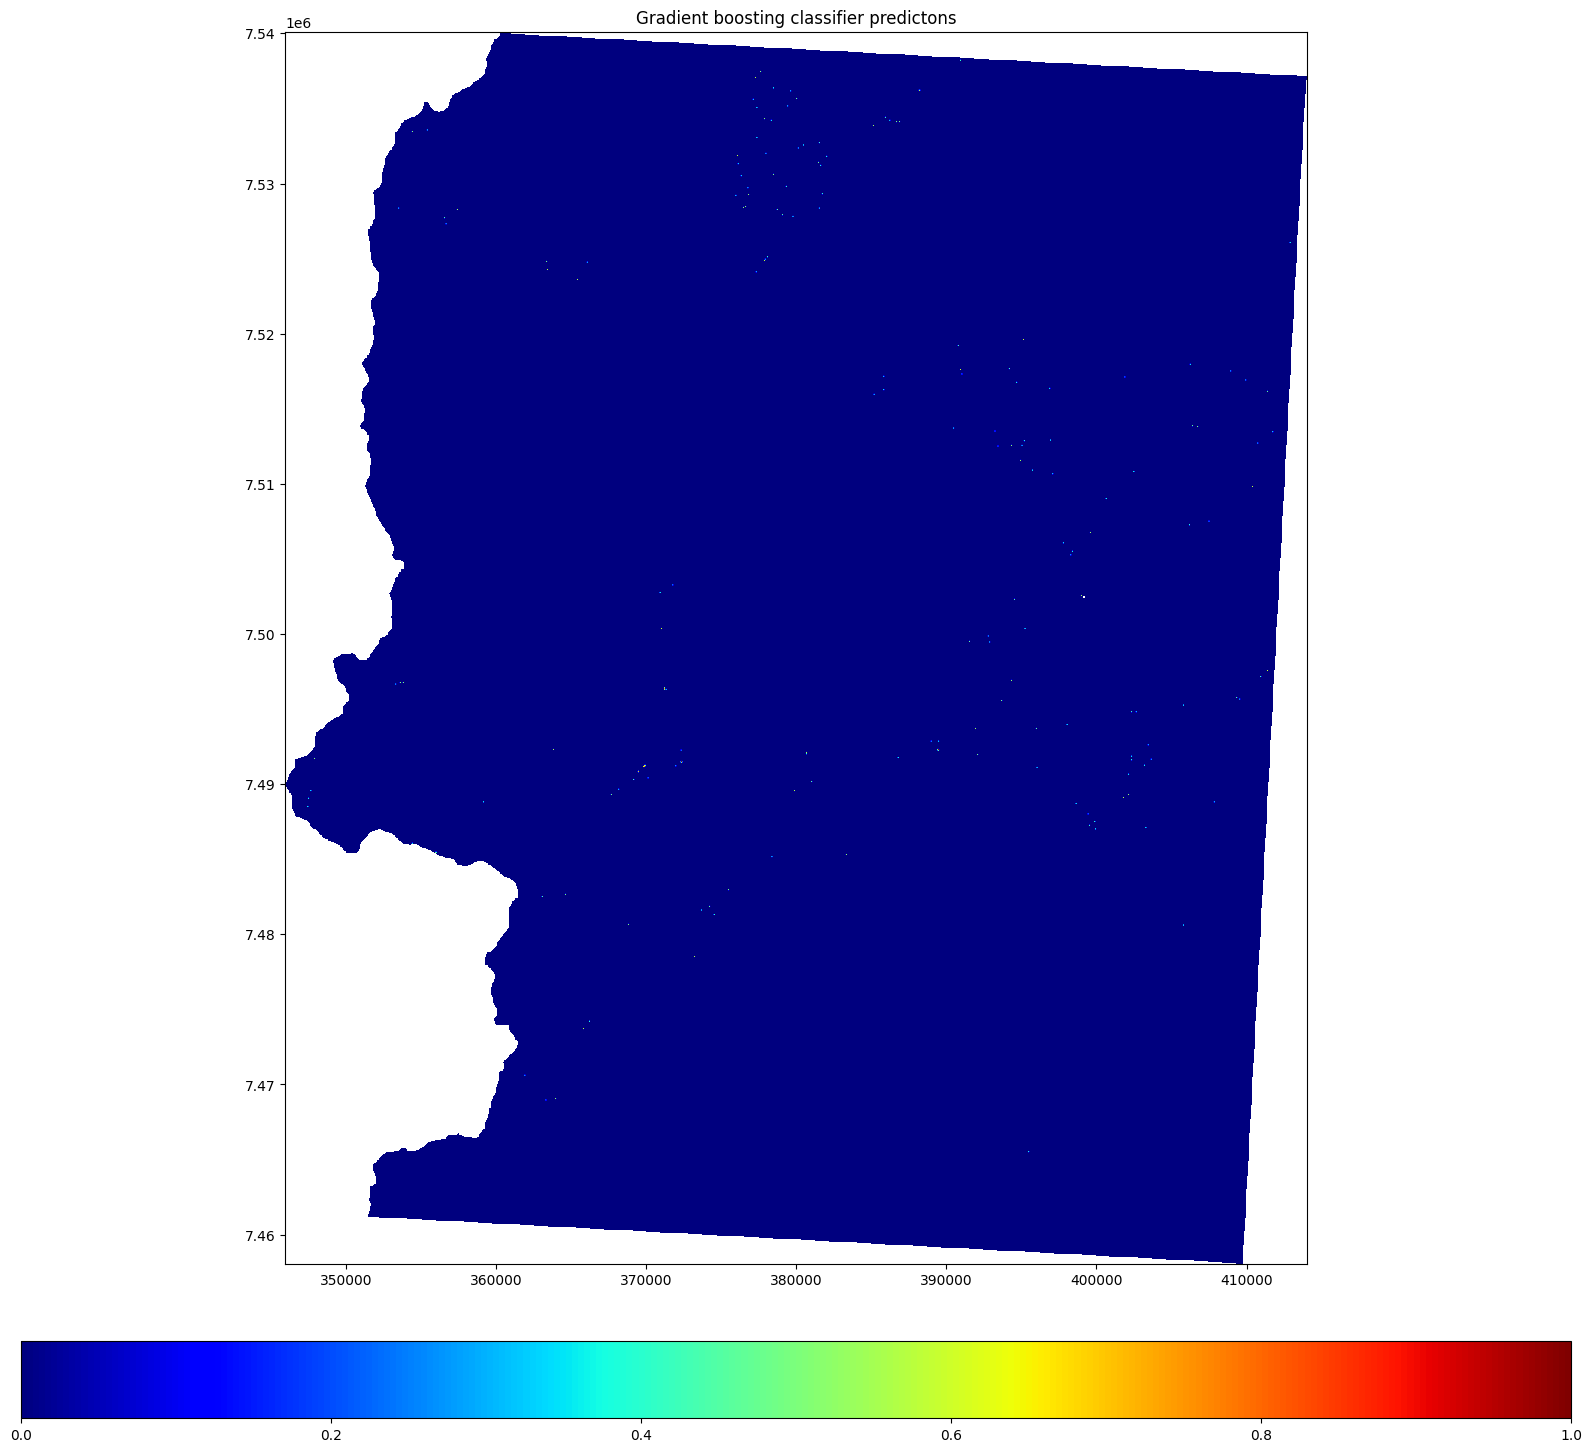

In [16]:
# Visualize output
fig, ax = plt.subplots(figsize = (20, 20))

ax.set_title("Gradient boosting classifier predictons")
clrbar = ax.imshow(gb_predictions_reshaped, cmap=colormap_name)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(gb_predictions_reshaped, ax = ax, transform = reference_meta["transform"], cmap=colormap_name)

In [17]:
gb_classifier_predictions_fp = "../tests/data/local/workflow_demo/clipped/gb_classifier_predictions_output.tif"
if save:
    with rasterio.open(gb_classifier_predictions_fp, "w", **reference_meta) as dest:
        dest.write(gb_predictions_reshaped, 1)